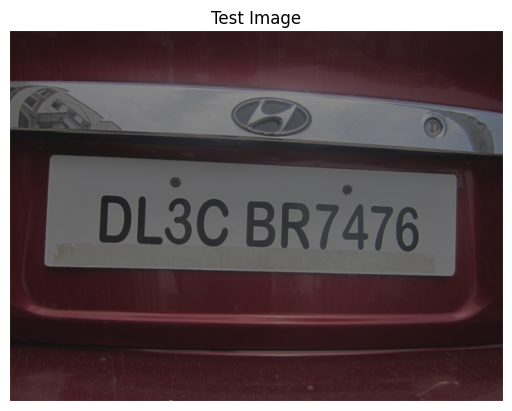

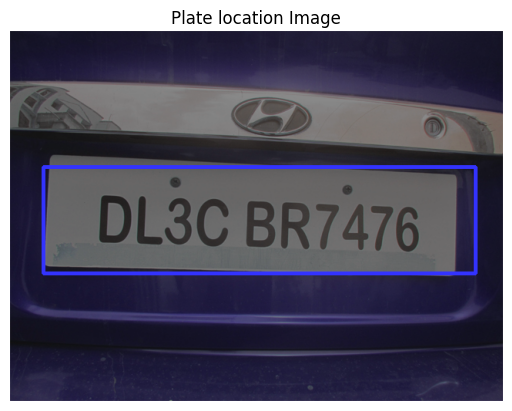

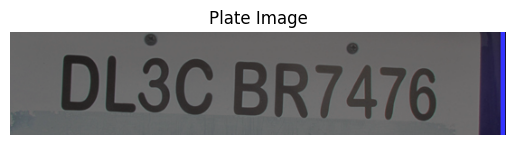

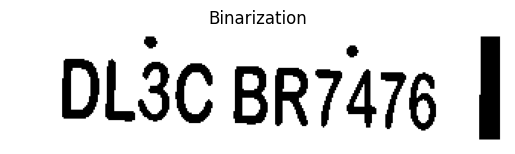

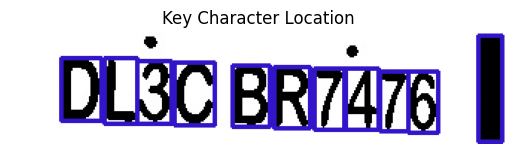

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 32)        55328     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 flatten_8 (Flatten)         (None, 6272)              0         
                                                                 
 dense_16 (Dense)            (None, 128)               802944    
                                                                 
 dense_17 (Dense)            (None, 

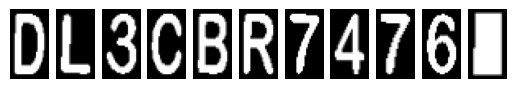

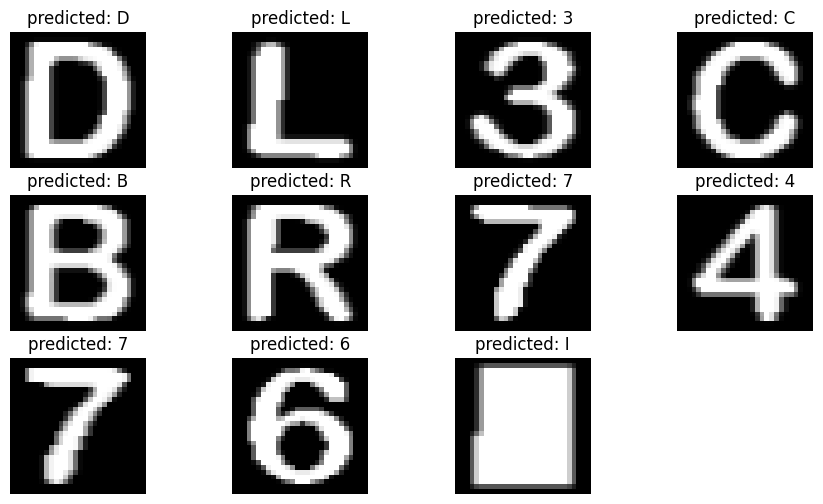

In [10]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
def find_contours(dimensions, img) :

   
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]

   
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]

    ii = cv2.imread('contour.jpg')

    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)

     
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) 

            char_copy = np.zeros((44,24))
            
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))

            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')


            char = cv2.subtract(255, char)

           
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) 

    
    plt.axis("off")
    plt.title("Key Character Location")
    plt.show()

 
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

def segment_characters(image) :

    
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

   
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

  
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.axis("off")
    plt.title("Binarization")
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()

    cv2.imwrite('contour.jpg',img_binary_lp)

   
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list
img=cv2.imread('/content/4.png')
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis("off")
plt.title("Test Image")
plt.show()
plate_img = img.copy()
plate_cascade = cv2.CascadeClassifier('./indian_license_plate.xml')
plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor = 1.3, minNeighbors = 7)
x=plate_rect[0,0]
y=plate_rect[0,1]
w=plate_rect[0,2]
h=plate_rect[0,3]
a,b = (int(0.025*img.shape[0]), int(0.025*img.shape[1])) #parameter tuning
cv2.rectangle(plate_img, (x,y), (x+w+10, y+h), (51,51,255), 3)
plt.imshow(plate_img)
plt.axis("off")
plt.title("Plate location Image")
plt.show()

plate=plate_img[y+a:y+h-a, x+b:x+w-b+30]
plt.imshow(plate)
plt.axis("off")
plt.title("Plate Image")
plt.show()

char = segment_characters(plate)
import zipfile
import os
import shutil
with zipfile.ZipFile("data.zip","r") as f:
    f.extractall('.')
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
train_generator = train_datagen.flow_from_directory(
        'data/train',  
        target_size=(28,28),  
        batch_size=1,
        class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
        'data/val',  
        target_size=(28,28), 
        class_mode='categorical')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from tensorflow.keras import optimizers
model = Sequential()
model.add(Conv2D(32, (24,24), input_shape=(28, 28, 3), activation='relu', padding='same'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))
model.summary()

batch_size = 1
print("Character Segmentation")
print(len(char))
flen=len(char)
for i in range(flen):
    plt.subplot(1, flen, i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')

model = tf.keras.models.load_model('Seg-cnn.h5')
def fix_dimension(img):
  new_img = np.zeros((28,28,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img

def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): 
        img_ = cv2.resize(ch, (28,28))
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) 
        y_ = model.predict(img)[0] 
        classes_x=np.argmax(y_ )
        character = dic[classes_x] 
        if(character=='8'):
          character='B'
        if(character=='O'):
          character='D'
        if(character=='A'):
          character='4'
        output.append(character) 

    plate_number = ''.join(output)

    return plate_number
print('Character Recognized')
print(show_results())
plt.figure(figsize=(flen,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28))
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()